In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None) 

#plt.style.use('seaborn')
sns.set_theme(style="white")

train_df = pd.read_csv('data/train_ml.csv', index_col=0)
test_df = pd.read_csv('data/test_ml.csv', index_col=0)

# I. Data exploration

In [98]:
X_full = train_df.copy(deep=True)
X_full_test = test_df.copy(deep=True)

In [99]:
print("There are", X_full.shape[0], "emails in train dataset and", test_df.shape[0], "in the test set.")
print("The dimension of the eval dataset in comparaison of the dataset is {0:.0%}.".format(test_df.shape[0]/(test_df.shape[0]+X_full.shape[0])))

There are 39671 emails in train dataset and 17002 in the test set.
The dimension of the eval dataset in comparaison of the dataset is 30%.


In [100]:
label_dict = {
    'updates':0,
    'personal':1,
    'promotions':2,
    'forums':3,
    'purchases':4,
    'travel':5,
    'spam':6,
    'social':7
}

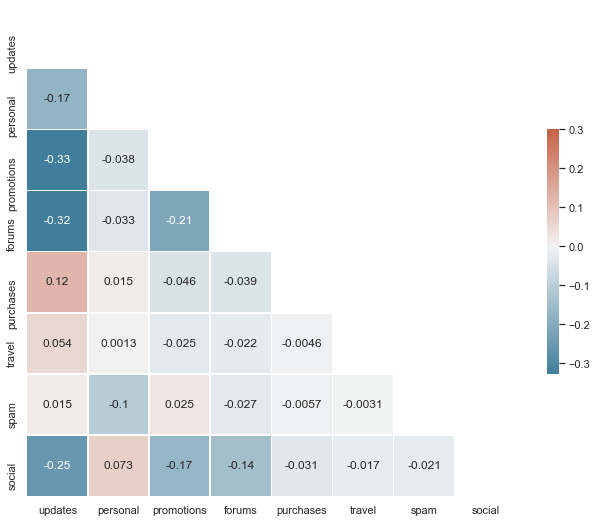

In [101]:
corr = X_full[label_dict.keys()].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

We notice that some mails are classified in several categories and that the categories to be predicted are therefore not disjointed.

We now consider how many mails are common to several categories and what are these categories.

In [102]:
corr_count = np.zeros((8,8), dtype=int)

i = 0
for label1 in label_dict:
    j=0
    for label2 in label_dict:
        corr_count[i][j] = sum(X_full.apply(lambda x: 1 if (x[label1] == 1 and x[label2] == 1) else 0, axis=1))
        j += 1
    i +=1

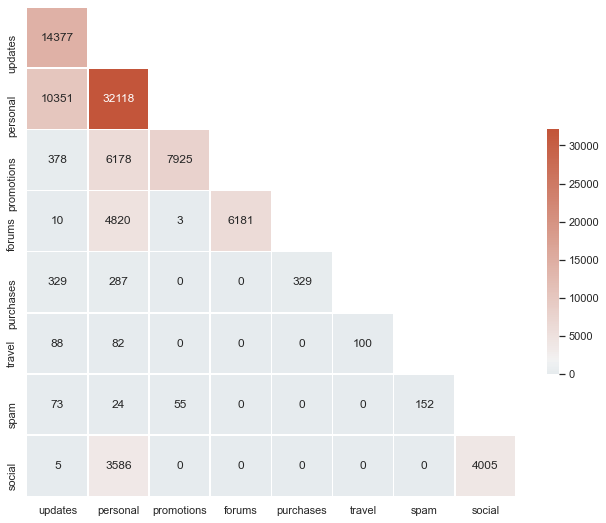

In [103]:
df_corr_count = pd.DataFrame(corr_count, index=label_dict.keys(), columns=label_dict.keys(), dtype=int)
mask = np.triu(np.ones_like(df_corr_count, dtype=bool), k=1)
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_corr_count, mask=mask, cmap=cmap, center=df_corr_count.mean().mean(), vmax=df_corr_count.max().max(),
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt="n")
plt.show()

Categorie `updates` is very oft associated with `personal`.
Categorie `promotions` is oft associated with `personal`.

There is an unequal number of items in each category. For example, `personal` often appears when `travel` does not.

We look if there are emails that belong to more than 2 categories.

In [104]:
X_full['number_labels'] = X_full.apply(lambda x: sum([x[col] for col in label_dict.keys()]), axis=1)

In [105]:
print("There are", len(X_full[X_full['number_labels']>2]), "emails that belong to more than 2 categories, so {0:.0%} of the dataset.".format(len(X_full[X_full['number_labels']>2])/X_full.shape[0]))

There are 753 emails that belong to more than 2 categories, so 2% of the dataset.


These are emails belonging in 3 categories and they are marginal.

In [106]:
ProfileReport(X_full).to_widgets()

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Column CCS

In [24]:
n_ccs = 1
print("There is only {0:.0%} of the dataset of emails with more than".format((X_full['ccs'].where(X_full['ccs']>=n_ccs).count())/X_full.shape[0]), str(n_ccs), "CCS.")

There is only 14% of the dataset of emails with more than 1 CCS.


## Column images

In [108]:
n_images = 10
print("There is only {0:.0%} of the dataset of emails with more than".format(X_full['images'].where(X_full['images']>=n_images).count()/X_full.shape[0]), str(n_images), "images.")

There is only 24% of the dataset of emails with more than 10 images.


## Column urls

In [109]:
n_urls = 50
print("There is only {0:.0%} of the dataset of emails with more than".format(X_full['urls'].where(X_full['urls']>=n_urls).count()/X_full.shape[0]), str(n_urls), "urls.")

There is only 24% of the dataset of emails with more than 50 urls.


## Column mail_type

In [110]:
def clean_mail_type(etype):
    if type(etype) != str and np.isnan(etype):
        return 'text/plain'
    if (('multipart/' in etype or etype == 'text/calendar') and not(etype in ['multipart/alternative', 'multipart/mixed'])):
        return 'multipart/others'
    else:
        return etype.strip().lower()

In [111]:
X_full['mail_type'] = X_full['mail_type'].apply(clean_mail_type)
X_full['mail_type'].value_counts()

multipart/alternative    28196
text/html                 5635
multipart/mixed           3405
text/plain                1495
multipart/others           940
Name: mail_type, dtype: int64

## Columns org & tld

In [112]:
n_org = 56
print("The first", str(n_org), "have an occurence of more than", str(X_full['org'].value_counts().iloc[n_org]), "in the dataset.")

n_tld = 23
print("The first", str(n_tld), "have an occurence of more than", str(X_full['tld'].value_counts().iloc[n_tld]), "in the dataset.")

The first 56 have an occurence of more than 101 in the dataset.
The first 23 have an occurence of more than 109 in the dataset.


## Column date
We convert now the column `date` to python's date format.

In [113]:
def clean_date(date):
    # Remove occurences of GMT
    pre_date = date.split('GMT', 1)[0].split('(', 1)[0]
    
    # replace - with ' '
    pre_date = pre_date.replace('-', ' ')
    
    # remove multiple spaces
    pre_date = ' '.join(pre_date.split())
    
    # remove space at the beginning and the end
    words_list = pre_date.strip().split(' ')
    
    if words_list[0][:-1].isalpha():
        # We have the weekday
        words_list.pop(0)
    if len(words_list[0]) == 1:
        words_list[0] = '0' + words_list[0]
    assert len(words_list[0]) == 2, 'For date ' + date
    
    words_list[1] = words_list[1].capitalize()
    
    if len(words_list[2]) == 2:
        words_list[2] = '20' + words_list[2]
    assert len(words_list[2]) == 4, 'For date ' + date
              
    # Remove parenthesis
    if not(words_list[-1][0] in ['+', '-']):
        if words_list[-1][0] == '(':
            words_list.pop()

        # Add +0000 if not precised
        if not(words_list[-1][0] in ['+', '-']):
            if words_list[-1].isnumeric():
                words_list[-1] = '+' + words_list[-1]
            else:
                words_list.append('+0000')
        
    # Correct some errors
    if int(words_list[-1][3:]) > 60:
        words_list[-1] = str(int(words_list[-1][1:3])+1) + '00'
        if len(words_list[-1]) == 3:
            words_list[-1] = '+0' + words_list[-1]
        else:
            words_list[-1] = '+' + words_list[-1]
                
    assert int(words_list[-1][3:]) <= 60, 'For date ' + date + '. UTC offset : ' + words_list[-1]
    clean_date = ' '.join(''.join(map(str, word)) for word in words_list)
    assert len(clean_date) == 26, 'For date ' + date + '. Output : ' + clean_date + '. Len : ' + str(len(clean_date))
    return clean_date

In [114]:
X_full['date'] = pd.to_datetime(train_df['date'].apply(clean_date), format="%d %b %Y %X %z", utc=True)
X_full_test['date'] = pd.to_datetime(test_df['date'].apply(clean_date), format="%d %b %Y %X %z", utc=True)

We average the number of emails received over 2 months in order to smooth curves and noise a priori.

In [115]:
X_full_time = X_full.groupby(by="date").sum()[label_dict.keys()]
X_full_months = X_full_time.groupby(pd.Grouper(freq="2M")).sum()

X_full_test_time = X_full_test.pivot_table(index=['date'], aggfunc='size')
X_full_test_months = X_full_test_time.groupby(pd.Grouper(freq="2M")).sum()

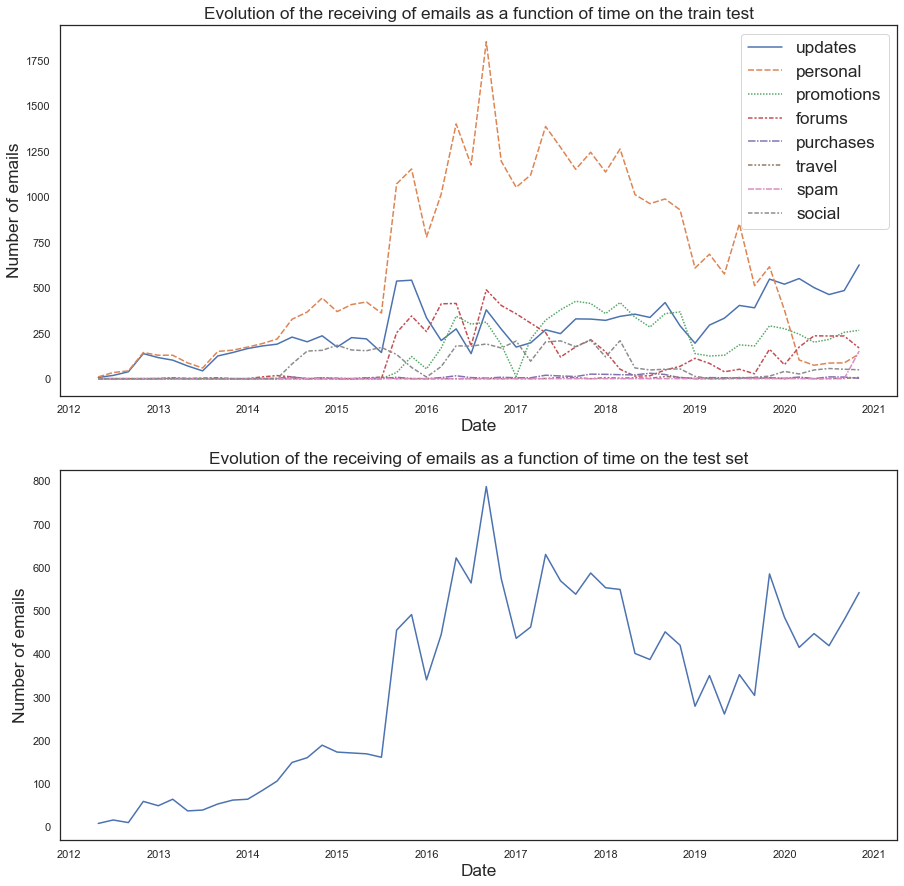

In [116]:
f = plt.figure(figsize=(15, 15))
gs = f.add_gridspec(2, 1)

with sns.axes_style("white"):
    ax = f.add_subplot(gs[0, 0])
    sns.lineplot(data=X_full_months)
    plt.title('Evolution of the receiving of emails as a function of time on the train test', fontsize="x-large")
    plt.ylabel('Number of emails', fontsize="x-large")
    plt.xlabel('Date', fontsize="x-large")
    plt.legend(fontsize='x-large')

with sns.axes_style("white"):
    ax = f.add_subplot(gs[1, 0])
    sns.lineplot(data=X_full_test_months)
    plt.title('Evolution of the receiving of emails as a function of time on the test set', fontsize="x-large")
    plt.ylabel('Number of emails', fontsize="x-large")
    plt.xlabel('Date', fontsize="x-large")
    
plt.show()

The information of date is therefore pretty important and should be considered.

Does it exist seasonalities during years ?

In [117]:
from datetime import date

start_date = date(2018,1,1)
end_date = date(2020,1,1)

mask = (X_full_time.index.date > start_date) & (X_full_time.index.date <= end_date)
X_cut_weeks = X_full_time.loc[mask].groupby(pd.Grouper(freq="2W")).sum()

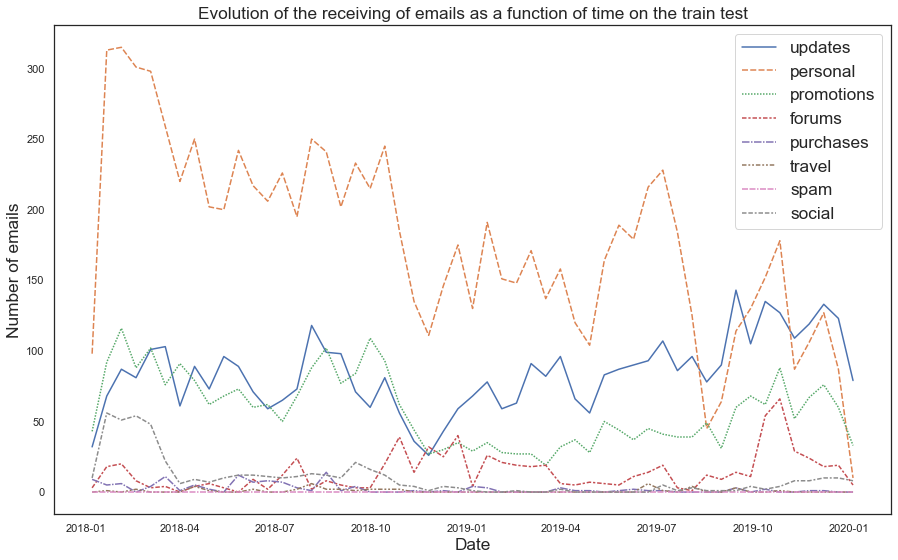

In [118]:
f, ax = plt.subplots(figsize=(15, 9))

sns.lineplot(data=X_cut_weeks)
plt.title('Evolution of the receiving of emails as a function of time on the train test', fontsize="x-large")
plt.ylabel('Number of emails', fontsize="x-large")
plt.xlabel('Date', fontsize="x-large")
plt.legend(fontsize='x-large')
plt.show()

There are some seasonalities but they remain not obvious. We will try to compute them.

# II. Feature engineering

In [87]:
def clean_mail_type(etype):
    if type(etype) != str and np.isnan(etype):
        return 'text/plain'
    if (('multipart/' in etype or etype == 'text/calendar') and not(etype in ['multipart/alternative', 'multipart/mixed'])):
        return 'multipart/others'
    else:
        return etype.strip().lower()

In [88]:
def clean_date(date):
    # Remove occurences of GMT
    pre_date = date.split('GMT', 1)[0].split('(', 1)[0]
    
    # replace - with ' '
    pre_date = pre_date.replace('-', ' ')
    
    # remove multiple spaces
    pre_date = ' '.join(pre_date.split())
    
    # remove space at the beginning and the end
    words_list = pre_date.strip().split(' ')
    
    if words_list[0][:-1].isalpha():
        # We have the weekday
        words_list.pop(0)
    if len(words_list[0]) == 1:
        words_list[0] = '0' + words_list[0]
    assert len(words_list[0]) == 2, 'For date ' + date
    
    words_list[1] = words_list[1].capitalize()
    
    if len(words_list[2]) == 2:
        words_list[2] = '20' + words_list[2]
    assert len(words_list[2]) == 4, 'For date ' + date
              
    # Remove parenthesis
    if not(words_list[-1][0] in ['+', '-']):
        if words_list[-1][0] == '(':
            words_list.pop()

        # Add +0000 if not precised
        if not(words_list[-1][0] in ['+', '-']):
            if words_list[-1].isnumeric():
                words_list[-1] = '+' + words_list[-1]
            else:
                words_list.append('+0000')
        
    # Correct some errors
    if int(words_list[-1][3:]) > 60:
        words_list[-1] = str(int(words_list[-1][1:3])+1) + '00'
        if len(words_list[-1]) == 3:
            words_list[-1] = '+0' + words_list[-1]
        else:
            words_list[-1] = '+' + words_list[-1]
                
    assert int(words_list[-1][3:]) <= 60, 'For date ' + date + '. UTC offset : ' + words_list[-1]
    clean_date = ' '.join(''.join(map(str, word)) for word in words_list)
    assert len(clean_date) == 26, 'For date ' + date + '. Output : ' + clean_date + '. Len : ' + str(len(clean_date))
    return clean_date

In [104]:
X_full = train_df.copy(deep=True)
X_full_test = test_df.copy(deep=True)

y_col = ['updates', 'personal', 'promotions', 'forums', 'purchases', 'travel', 'spam', 'social']
y = X_full[y_col]
X_full.drop(y_col, axis=1, inplace=True)

In [105]:
X_full['date'] = pd.to_datetime(train_df['date'].apply(clean_date), format="%d %b %Y %X %z", utc=True)
X_full_test['date'] = pd.to_datetime(test_df['date'].apply(clean_date), format="%d %b %Y %X %z", utc=True)

In [106]:
X_full['mail_type'] = X_full['mail_type'].apply(clean_mail_type)
X_full_test['mail_type'] = X_full_test['mail_type'].apply(clean_mail_type)

In [107]:
X_full['images/body'] = X_full['images']/X_full['chars_in_body']
X_full_test['images/body'] = X_full_test['images']/X_full_test['chars_in_body']

In [108]:
X_full['salutations&designation'] = X_full['salutations'] & X_full['designation']
X_full_test['salutations&designation'] = X_full_test['salutations'] & X_full_test['designation']

We verify that the stratification was good.

In [109]:
#y_test.sum(axis=0)/(y_train.sum(axis=0) + y_test.sum(axis=0))

We now do some feature engineering.

In [110]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import date

class DateTransformer(BaseEstimator, TransformerMixin):
    """Transformer for date."""
    def __init__(self, active=True):
        self.active=active
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        if self.active:
            X_new['year'] = X['date'].dt.year
            X_new['month//2'] = X['date'].dt.month//2
            X_new['weekday'] = X['date'].dt.weekday
            X_new['trimester_from_2012'] = (X['date'].dt.date- date(2012,1,1)).dt.days//(7*13)
            X_new['hours'] = X['date'].dt.hour
        return X_new[['year', 'month//2', 'weekday', 'trimester_from_2012', 'hours']]

class BoundedLabelTransformer(BaseEstimator, TransformerMixin):
    """Transformer for org and tld."""
    def __init__(self, org=56, tld=23):
        self.org = org
        self.tld = tld
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X[['org', 'tld']].copy()
        for column in ['org', 'tld']:
            X_new[column] = X_new[column].fillna('unknown')
            if column == 'org':
                keep_labels = list(X[column].value_counts()[:self.org].index)
            else:
                keep_labels = list(X[column].value_counts()[:self.tld].index)
            X_new[column] = X_new[column].apply(lambda x : x if x in keep_labels else '__others')
        return X_new


class BoundedOrdinalTransformer(BaseEstimator, TransformerMixin):
    """Transformer for images and urls."""
    def __init__(self, images=10, urls=50):
        self.images = images
        self.urls = urls
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X[['images', 'urls']].copy()
        
        for column in ['images', 'urls']:
            X_new[column] = X_new[column].fillna(0)
            if column == 'images':
                X_new[column] = X_new[column].apply(lambda x : x if x < self.images else self.images)
            else:
                X_new[column] = X_new[column].apply(lambda x : x if x < self.urls else self.urls) 
        
        #X_new['images/body'] = X['images']/X['chars_in_body']
        return X_new.values

In [119]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer

date_cat = ['date']
bounded_label_cat = ['org', 'tld']
bounded_ordinal_cat = ['images', 'urls']
binary_cat = ['ccs', 'bcced', 'salutations', 'designation', 'salutations&designation']
label_cat = ['mail_type']
continuous_cat = ['chars_in_subject', 'chars_in_body', 'images/body']

Bounded_label_lin = make_pipeline(
    BoundedLabelTransformer(org=56, tld=23),
    OneHotEncoder(handle_unknown='ignore')
)

Label_lin = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='text/plain'),
    OneHotEncoder(handle_unknown='ignore')
)

Countinuous_lin = make_pipeline(
    SimpleImputer(strategy='mean'),
    RobustScaler()
)

processor_lin = make_column_transformer(
    (DateTransformer(active=True), date_cat),
    (Bounded_label_lin, bounded_label_cat),
    (BoundedOrdinalTransformer(images=10, urls=50), bounded_ordinal_cat),
    (Label_lin, label_cat),
    (Countinuous_lin, continuous_cat),
    (SimpleImputer(strategy='constant', fill_value=0), binary_cat)
)

# III. Testing models

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier

classifiers = {
    'duc' : make_pipeline(processor_lin, OneVsRestClassifier(DummyClassifier(strategy='prior', random_state=1))),
    'rfc' : make_pipeline(processor_lin, OneVsRestClassifier(RandomForestClassifier(random_state=1))),
    'gbc' : make_pipeline(processor_lin, OneVsRestClassifier(GradientBoostingClassifier(random_state=1))),
    'xgc' : make_pipeline(processor_lin, OneVsRestClassifier(XGBClassifier(random_state=1, verbose=True, eval_metric='logloss'))),
    'mpc' : make_pipeline(processor_lin, OneVsRestClassifier(MLPClassifier(random_state=1))),
    #'svc' : make_pipeline(processor_lin, OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=1))),
}

Iterating over all classifiers before making fine tuning.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

res_clf = {}
for name, classifier in classifiers.items():
    print('Training', name, '...')
    if name=='xgc':
        X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.25, random_state=1, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1, stratify=y_train) # 0.20 x 0.75 = 0.15
        
        classifier.set_params(onevsrestclassifier__estimator__eval_set=[(X_train, y_train), (X_test, y_test)])
        %time classifier.fit(X_train, y_train)
        
        y_test_pred = classifier.predict_proba(X_test)
        res_clf[name] = log_loss(y_test, y_test_pred)   

    else:
        X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.25, random_state=1, stratify=y)
        
        %time classifier.fit(X_train, y_train)
        
        y_test_pred = classifier.predict_proba(X_test)
        res_clf[name] = log_loss(y_test, y_test_pred) 

    print(res_clf[name])
res_clf

We have the following input :
```
Training duc ...
Wall time: 189 ms
2.2743314534065138
Training rfc ...
Wall time: 48.2 s
1.1948558276322874
Training gbc ...
Wall time: 28.7 s
1.382503328344713
Training xgc ...
Wall time: 7.18 s
1.3540913110325103
Training mpc ...
Wall time: 52.9 s
1.6615107416581647
Training svc ...
```
We notice that SVC takes too more times to fit. We will not consider it. We notice that the most promising algorithms is the **Random Forest**.

## IV. Fine Tuning

In [126]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'columntransformer__pipeline-1__boundedlabeltransformer__org' : [20,40,50,50,60,70],
    'columntransformer__pipeline-1__boundedlabeltransformer__tld' : [10,15,20,20,25,30],
    'columntransformer__boundedordinaltransformer__images' : [3,5,8,8,10,12,15],
    'columntransformer__boundedordinaltransformer__urls' : [10,20,20,30,40,50],
    'onevsrestclassifier__estimator__bootstrap': [True, True, False],
    'onevsrestclassifier__estimator__min_samples_leaf': [1,1,2,3,5,10,50],
    'onevsrestclassifier__estimator__min_samples_split': [2,3,4,4,5,7,10],
    'onevsrestclassifier__estimator__n_estimators': [100,200,300,400,500,600,700,800]
}

number_possibilites = 1
for key, value in param_dist.items():
    number_possibilites = number_possibilites * len(value)

print("There are", str(number_possibilites), "possibilites for the RandomizedSearchCV.")

There are 1778112 possibilites for the RandomizedSearchCV.


In [33]:
from sklearn.metrics import log_loss

random_search =RandomizedSearchCV(
    estimator=classifiers['rfc'],
    param_distributions=param_dist,
    scoring='neg_log_loss',
    n_iter=4,
    cv=2,
    verbose=1,
    random_state=1,
    n_jobs=-1,
    return_train_score=True)

%time random_search.fit(X_full, y);

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.5s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    4.0s finished


We then export the results into JSON.

In [29]:
import json

parsed = json.loads(pd.DataFrame(random_search.cv_results_).to_json())

with open('results.json', "w") as f:
        json.dump(parsed,f)

Using the help of Tony to fine tune, we obtain the following results for the Randomized Search :

```
{'onevsrestclassifier_estimator_n_estimators': 700, 'onevsrestclassifierestimatormin_samples_split': 4, 'onevsrestclassifierestimatormin_samples_leaf': 1, 'onevsrestclassifierestimator_bootstrap': False, 'columntransformerpipeline-1boundedlabeltransformertld': 20, 'columntransformerpipeline-1boundedlabeltransformerorg': 50, 'columntransformer_boundedordinaltransformer_urls': 20, 'columntransformer_boundedordinaltransformer_images': 8}
```

In [42]:
import json
with open('ml_groundtruth/results.json', "r") as f:
    results = json.load(f)

In [125]:
type(results)

dict

In [124]:
with open('test.json', 'w') as f:
    json.dump(results, f)

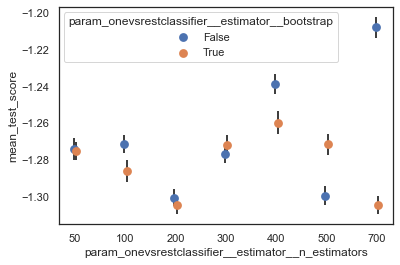

In [76]:
results_df = pd.DataFrame(results).groupby(by="param_onevsrestclassifier__estimator__n_estimators")

ax = sns.pointplot(x='param_onevsrestclassifier__estimator__n_estimators', y='mean_test_score',
                   hue='param_onevsrestclassifier__estimator__bootstrap',
                   data=pd.DataFrame(results), dodge=True, join=False, ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
errors = pd.DataFrame(results).groupby(by=["param_onevsrestclassifier__estimator__bootstrap", "param_onevsrestclassifier__estimator__n_estimators"]).mean()['std_test_score']
colors = ['black']*2 + ['black']*2
ax.errorbar(x_coords, y_coords, yerr=errors,ecolor=colors, fmt=' ', zorder=-1);

In [121]:
rfc = make_pipeline(processor_lin, OneVsRestClassifier(RandomForestClassifier(criterion='entropy', random_state=1), n_jobs=-1))

rfc.set_params(**{'onevsrestclassifier__estimator__n_estimators': 700, 'onevsrestclassifier__estimator__min_samples_split': 4, 'onevsrestclassifier__estimator__min_samples_leaf': 1, 'onevsrestclassifier__estimator__bootstrap': False, 'columntransformer__pipeline-1__boundedlabeltransformer__tld': 20, 'columntransformer__pipeline-1__boundedlabeltransformer__org': 50, 'columntransformer__boundedordinaltransformer__urls': 20, 'columntransformer__boundedordinaltransformer__images': 8})
rfc.fit(X_full, y)
pred_y = rfc.predict_proba(X_full_test)

In [122]:
pred_df = pd.DataFrame(pred_y, columns=['updates', 'personal', 'promotions',
                        'forums', 'purchases', 'travel',
                        'spam', 'social'])
pred_df.to_csv("submission_ml.csv", index=True, index_label='Id')